In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import sklearn as sk
import seaborn as sns

## preprocessing

In [2]:
raw_data = scp.io.arff.loadarff('data/EEG Eye State.arff')
df = pd.DataFrame(raw_data[0])
df['eyeDetection'] = df['eyeDetection'].apply(lambda x: int(x.decode()))

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, stratify=y, test_size=0.2)

scaler = sk.preprocessing.StandardScaler()
X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)

Check for y distribution. Balanced due to stratification

In [3]:
unique_train, train_counts = np.unique(y_train, return_counts=True)
unique_test, test_counts = np.unique(y_test, return_counts=True)
print(f'Train label distribution: {dict(zip(unique_train, train_counts))}')
print(f'Test label distribution: {dict(zip(unique_test, test_counts))}')

Train label distribution: {0: 6606, 1: 5378}
Test label distribution: {0: 1651, 1: 1345}


## initial visualisation

## PCA

In [4]:
init_pca = sk.decomposition.PCA(n_components=14)
init_pca_fit = init_pca.fit(X_train_scaled)

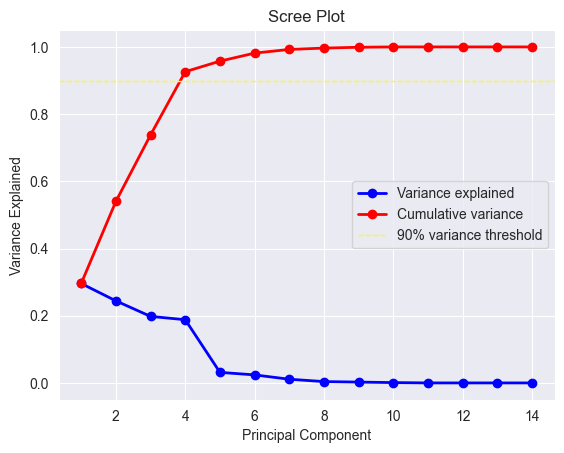

In [5]:
init_PC_values = np.arange(init_pca.n_components_) + 1
init_variance = np.cumsum(init_pca.explained_variance_ratio_)

plt.plot(init_PC_values, init_pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue', label='Variance explained')
plt.plot(init_PC_values, init_variance, 'o-', linewidth=2, color='red', label='Cumulative variance')
plt.axhline(y=0.9, color='yellow', linestyle='--', linewidth=1, label='90% variance threshold')

plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')

plt.legend()
plt.show()

The drop in the scree plot is at PC4. the first 4 components account for 91.5% of the total variance. Therefore, I will only use the first four to look for clusters/patterns.

In [6]:
pca = sk.decomposition.PCA(n_components=4)
X_pca = pca.fit(X_train_scaled)

X_pca_train = pca.transform(X_train_scaled)
X_pca_test = pca.transform(X_test_scaled)

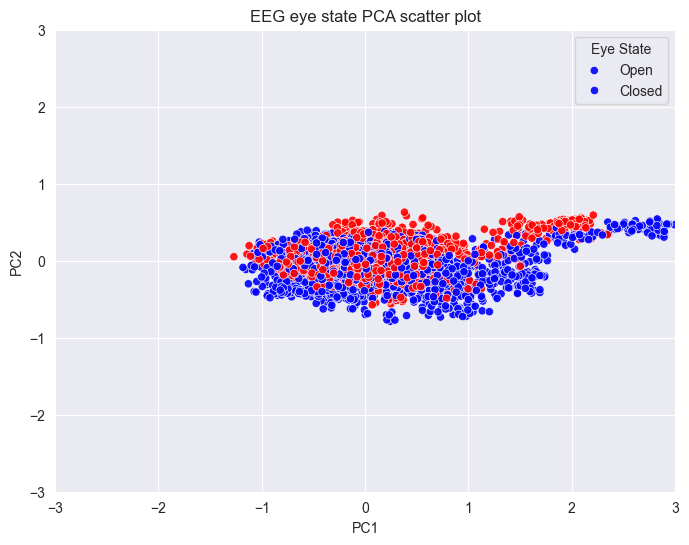

In [7]:
pca_df = pd.DataFrame(X_pca_train, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_df['eyeDetection'] = y_train

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='eyeDetection',
    palette={0:'blue', 1:'red'},
    alpha=0.9
)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('EEG eye state PCA scatter plot')
plt.legend(title='Eye State', labels=['Open', 'Closed'])
plt.show()

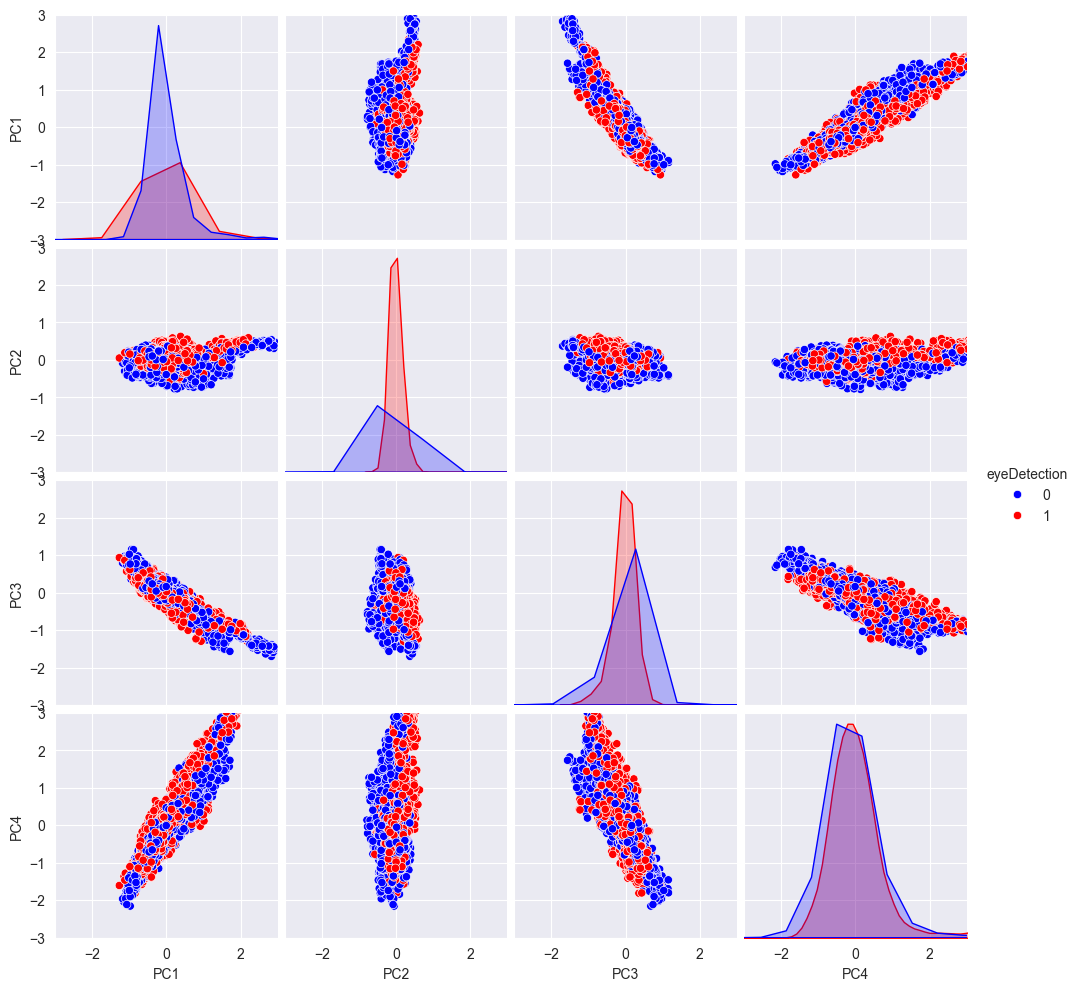

In [8]:
g = sns.pairplot(data=pca_df, hue='eyeDetection', palette={0: 'blue', 1: 'red'})

for ax in g.axes.flatten():
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
plt.show()

### Hyperparameter tuning for k-nearest neighbours

- number of neighbours = [1, 2,..., 40]
- weights = [uniform, distance]

I chose metrics according to this article https://www.kdnuggets.com/2020/11/most-popular-distance-metrics-knn.html

- metric = [eucliean, manhattan]

I then use the sklearn GridSearchCV method to see which combination is the best for this problem. This method requires:
- An estimator: kNN
- A parameter grid
- Scoring: accuracy
- cv: 5
- verbose: 1

Outputs printed will be:
- best_params to see which parameters performed the best
- best_index to return the index of the best combination

At this point I noticed that I was getting suspiciously low test accuracy ($\approx$ 39%). The y_test array turned out to be extremely unbalanced, so I went back and changed it to stratify y.

In [10]:
knn_parameters = {
    'n_neighbors' : [i for i in range(1, 41)],
    'weights' : ['uniform', 'distance'],
    'metric' : ['euclidean', 'manhattan']
}

knn = sk.neighbors.KNeighborsClassifier()

knn_param_search = sk.model_selection.GridSearchCV(estimator=knn,
                                                   param_grid=knn_parameters,
                                                   cv=5,
                                                   scoring='accuracy',
                                                   verbose=1)
knn_param_search.fit(X_pca_train, y_train)
print(f'kNN best parameters: {knn_param_search.best_params_}')
print(f'kNN index of best parameters: {knn_param_search.best_index_}')

knn_best = knn_param_search.best_estimator_
knn_test_pred = knn_best.predict(X_pca_test)
print(f'kNN test accuracy on best parameters: {sk.metrics.balanced_accuracy_score(y_test, knn_test_pred):.2f}')

Fitting 5 folds for each of 160 candidates, totalling 800 fits
kNN best parameters: {'metric': 'euclidean', 'n_neighbors': 21, 'weights': 'distance'}
kNN index of best parameters: 41
kNN test accuracy on best parameters: 0.66


### Hyperparameter tuning for SVM



- regularisation parameter C = [0.1, 1, 10, 20]
- kernel = rbf, as the data isn't linearly separable
- gamma for rbf = [scale, 0.001, 0.01, 0.1]

Again, using GridSearchCV with the same parameters as above.

In [12]:
svm = sk.svm.SVC()

svm_params = {
    'C' : [0.1, 1, 10, 20],
    'gamma' : ['scale', 0.001, 0.01, 0.1]
}

svm_param_search = sk.model_selection.GridSearchCV(svm,
                                                   param_grid=svm_params,
                                                   scoring='accuracy',
                                                   verbose=1)

svm_param_search.fit(X_pca_train, y_train)
print(f'SVM best parameters: {svm_param_search.best_params_}')
print(f'SVM index of best parameters: {svm_param_search.best_index_}')

svm_best = svm_param_search.best_estimator_
svm_test_pred = svm_best.predict(X_pca_test)
print(f'SVM test accuracy on best parameters: {sk.metrics.balanced_accuracy_score(y_test, svm_test_pred):.2f}')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
SVM best parameters: {'C': 20, 'gamma': 0.1}
SVM index of best parameters: 15
SVM test accuracy on best parameters: 0.58


### Hyperparameter Tuning for Random Forest Classifier

- estimators = [100, 200, 300, 400, 500]
- max depth = [None, 10, 20]

In [15]:
rf = sk.ensemble.RandomForestClassifier()

rf_params = {
    'n_estimators' : [i for i in range(100, 501, 100)],
    'max_depth' : [None, 10, 20]
}

rf_param_search = sk.model_selection.GridSearchCV(rf,
                                                   param_grid=rf_params,
                                                   scoring='accuracy',
                                                   verbose=1)

rf_param_search.fit(X_pca_train, y_train)
print(f'Random Forest best parameters: {rf_param_search.best_params_}')
print(f'Random Forest index of best parameters: {rf_param_search.best_index_}')

rf_best = rf_param_search.best_estimator_
rf_test_pred = rf_best.predict(X_pca_test)
print(f'Random Forest test accuracy on best parameters: {sk.metrics.balanced_accuracy_score(y_test, rf_test_pred):.2f}')

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Random Forest best parameters: {'max_depth': 20, 'n_estimators': 400}
Random Forest index of best parameters: 13
Random Forest test accuracy on best parameters: 0.66


Decided to research smoothing techniques. Found moving average: choose a fixed window (increment by some step) and calculate the average over it, then train on that.

Requires reinstantiated X and y arrays, as it can't be shuffled for time series smoothing.

In [17]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, shuffle=False)
scaler = sk.preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

define a moving average function to smooth the data

In [18]:
def moving_window(X, y, window_size=70, step=43, mean_mode=True):
    i = 0
    X_w, y_w = [], []
    mid = window_size // 2

    while (i+window_size) <= X.shape[0]:
        w = X[i:i+window_size, :]
        if mean_mode:
            means = w.mean(axis=0)
            X_w.append(means)
        else:
            median = np.median(w, axis=0)
            X_w.append(median)
        label = int(y[i+mid])
        y_w.append(label)
        i += step
    return np.vstack(X_w), np.vstack(y_w).ravel()

A function for finding the best moving average combination

In [19]:
window_sizes = [i for i in range(20, 160, 10)]
steps = [i for i in range(10, 50, 3)]
k_vals = [i for i in range(2, 40, 3)]

results = np.zeros((len(window_sizes), len(steps), len(k_vals)))

for a, w in enumerate(window_sizes):
    for b, s in enumerate(steps):
        X_train_smoothed, y_train_smoothed = moving_window(X=X_train_scaled, y=y_train, window_size=w, step=s)
        X_test_smoothed, y_test_smoothed = moving_window(X=X_test_scaled, y=y_test, window_size=w, step=s)

        for c, k in enumerate(k_vals):
            knn = sk.neighbors.KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean')
            knn.fit(X_train_smoothed, y_train_smoothed)
            prediction = knn.predict(X_test_smoothed)
            acc = sk.metrics.balanced_accuracy_score(y_test_smoothed, prediction)
            results[a, b, c] = acc

best_index = np.unravel_index(np.argmax(results), results.shape)
best_window = window_sizes[best_index[0]]
best_step = steps[best_index[1]]
best_k = k_vals[best_index[2]]
best_score = results[best_index]

print(f'Best test accuracy: {best_score:.4f}')
print(f'best parameters: window_size={best_window}, step={best_step}, k={best_k}')

Best test acuracy: 0.7344
best parameters: window_size=70, step=43, k=5


try the same but with all windows having 50% overlap, so step size is half the window size

In [204]:
window_sizes = [i for i in range(10, 160, 2)]
k_vals = [i for i in range(2, 40, 2)]

results = np.zeros((len(window_sizes), len(k_vals)))

for a, w in enumerate(window_sizes):
    X_train_smoothed, y_train_smoothed = moving_window(X=X_train_scaled, y=y_train, window_size=w, step=int(w/2))
    X_test_smoothed, y_test_smoothed = moving_window(X=X_test_scaled, y=y_test, window_size=w, step=int(w/2))

    for c, k in enumerate(k_vals):
        knn = sk.neighbors.KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean')
        knn.fit(X_train_smoothed, y_train_smoothed)
        prediction = knn.predict(X_test_smoothed)
        acc = sk.metrics.balanced_accuracy_score(y_test_smoothed, prediction)
        results[a, c] = acc

best_index = np.unravel_index(np.argmax(results), results.shape)
best_window = window_sizes[best_index[0]]
best_step = int(best_window/2)
best_k = k_vals[best_index[1]]
best_score = results[best_index]

print(f'Best test acuracy: {best_score:.4f}')
print(f'best parameters: window_size={best_window}, step={best_step}, k={best_k}')

Best test acuracy: 0.7024
best parameters: window_size=132, step=66, k=2


70/43 achieves 73.4% accuracy, with a little over 50% overlap so I will accept it.

In [205]:
X_train_smoothed, y_train_smoothed = moving_window(X=X_train_scaled, y=y_train, window_size=70, step=43)
X_test_smoothed, y_test_smoothed = moving_window(X=X_test_scaled, y=y_test, window_size=70, step=43)

In [206]:
model = sk.neighbors.KNeighborsClassifier(n_neighbors = 5)
model.fit(X_train_smoothed, y_train_smoothed)
smoothed_pred = model.predict(X_test_smoothed)
print(f'final test acc: {sk.metrics.balanced_accuracy_score(y_test_smoothed, smoothed_pred):.4f}')

final test acc: 0.7344
